In [6]:
import re, sys
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from dGbyG.Chemistry.Compound import Compound
from dGbyG.Chemistry.Reaction import Reaction
from dGbyG.utils.ChemFunc import *
from dGbyG.utils.constants import *

In [7]:
tecrdb = pd.read_csv('./data/experimental_dG_from_eQ/TECRDB.csv')

data={'COCOM00001': '[O-]C(=O)C1=C(Cl)C(Cl)=CC=C1',
      'COCOM00002': '[O-]C(=O)C1=CC(Cl)=CC(Cl)=C1',
      'COCOM00003': '[O-]C(=O)C1=C(Cl)C(Cl)=CC(Cl)=C1',
      'COCOM00004': '[O-]C(=O)C1=CC(Cl)=C(Cl)C(Cl)=C1',
      'COCOM00005': '[O-]C(=O)C1=CC(Br)=CC=C1',
      'COCOM00006': '[O-]C(=O)C1=CC(I)=CC=C1',
      'COCOM00007': 'NC1=C(C=C(Cl)C=C1)C([O-])=O',
      'COCOM00008': 'OC1=C(C=C(Cl)C=C1)C([O-])=O',
      'COCOM00009': 'CC1=C(C=C(Cl)C=C1)C([O-])=O',
      'COCOM00010': 'CCC(C)Cl',
      'COCOM00011': 'C[N+](C)(C)[O-]',
      'COCOM00012': 'CC(=O)C1=C[N+](=CC=C1)C1OC(COP([O-])(=O)OP([O-])(=O)OCC2OC(C(O)C2O)N2C=NC3=C(N)N=CN=C23)C(O)C1O',
      'COCOM00013': 'CC(=O)C1=CN(C=CC1)C1OC(COP([O-])(=O)OP([O-])(=O)OCC2OC(C(O)C2O)N2C=NC3=C(N)N=CN=C23)C(O)C1O'}
equilibrator_df = pd.DataFrame(data=data.items(), columns=['id', 'Smiles'], ).set_index(keys='id')

In [8]:
tecrdb_copy = tecrdb.loc[:,['description', 'reaction', 'K_prime', 'temperature', 'ionic_strength', 'p_h', 'p_mg']].copy()

for i in tecrdb_copy.index:
    r = tecrdb_copy.loc[i,'reaction']
    reaction = parse_equation(r)
    rxn = {}
    for name, coeff in reaction.items():
        name = name.strip()
        if c := re.match(r'^kegg:(C\d{5})$', name):
            kegg_entry = c.group(1)
            mol = to_mol(kegg_entry, 'kegg')
        elif c := re.match(r'^metanetx.chemical:(.+)$', name):
            metanetx_id = c.group(1)
            mol = to_mol(metanetx_id, 'metanetx')
        elif c := re.match(r'COCO:(.+)$', name):
            equilibrator_id = c.group(1)
            smiles = equilibrator_df.loc[equilibrator_id, 'Smiles']
            mol = to_mol(smiles, 'Smiles')
        else:
            print(i)

        if not mol:
            rxn = pd.NA
            break
        
        compound = Compound(mol)
        smiles = compound.Smiles
        rxn[smiles] = coeff
    
    rxn = build_equation(rxn) if pd.notna(rxn) else pd.NA
    tecrdb_copy.loc[i,'reaction'] = rxn

C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01650 is tRNA(Ser), which has no Molfile
C01650 is tRNA(Ser), which has no Molfile
C01650 is tRNA(Ser), which has no Molfile
C01650 is tRNA(Ser), which has no Molfile
C01650 is tRNA(Ser), which has no Molfile
C01650 is tRNA(Ser), which has no 

In [9]:
tecrdb_copy = tecrdb_copy.loc[pd.notna(tecrdb_copy.loc[:,['reaction', 'K_prime']]).all(axis=1),:]
tecrdb_copy = tecrdb_copy.rename(columns={'temperature':'T', 'ionic_strength':'I', 'p_h':'pH', 'p_mg':'pMg'})
nontrans_standard_dg_primes = [(-R * row.T * np.log(row.K_prime)) for row in tecrdb_copy.itertuples()]
tecrdb_copy = tecrdb_copy.assign(**{"nontrans_standard_dg_primes": nontrans_standard_dg_primes})

In [10]:
balanced = []
for i in tecrdb_copy.index:
    r = tecrdb_copy.loc[i, 'reaction']
    r = Reaction(r, rxn_type='str', cid_type='smiles')
    if not r.is_balanced():
        balanced.append(False)
    else:
        r.balance()
        tecrdb_copy.loc[i, 'reaction'] = r.equationSmiles
        balanced.append(True)
tecrdb_copy = tecrdb_copy.loc[balanced, :]

{'O': 0, 'C': -8, 'N': 0, 'S': 0, 'H': -5, 'charge': 0, '*': 1}
{'O': 0, 'C': 18, 'P': 0, 'N': 4, 'S': 0, 'H': -1, 'charge': 0, '*': 21}
{'O': 0, 'C': 84.0, 'H': 58.0, 'charge': 0, '*': 8.0, 'N': 16.0, 'S': 4.0}


In [11]:
ddg_prime = np.array([])
for row in tecrdb_copy.itertuples():
    R = Reaction(row.reaction)
    condition = {'T':row.T}
    condition['pH'] = row.pH if pd.notna(row.pH) else default_pH
    condition['I'] = row.I if pd.notna(row.I) else default_I
    condition['pMg'] = row.pMg if pd.notna(row.pMg) else default_pMg
    if R.can_be_transformed:
        ddg_prime = np.append(ddg_prime, R.transform(condition, default_condition))
    else:
        print(R.equationSmiles)
tecrdb_copy.loc[:,'standard_dg_primes'] = tecrdb_copy.loc[:,'nontrans_standard_dg_primes'] + ddg_prime

In [12]:
tecrdb_dedup = pd.DataFrame(index=range(len(set(tecrdb_copy.reaction))), 
                            columns=['description', 'reaction', 'nontrans_standard_dg_prime','standard_dg_prime',
                                     'nontrans_stderr', 'stderr', 'n', 'SEM'])
i = 0
tecrdb_copy.index = tecrdb_copy.reaction
for r in set(tecrdb_copy.index):
    reaction = tecrdb_copy.loc[[r],:]
    tecrdb_dedup.loc[i,'description'] = reaction.loc[:,'description'][0]
    tecrdb_dedup.loc[i,'reaction'] = r
    tecrdb_dedup.loc[i,'nontrans_standard_dg_prime'] = reaction.loc[:,'nontrans_standard_dg_primes'].mean()
    tecrdb_dedup.loc[i,'standard_dg_prime'] = reaction.loc[:,'standard_dg_primes'].mean()
    tecrdb_dedup.loc[i,'nontrans_stderr'] = reaction.loc[:,'nontrans_standard_dg_primes'].std(ddof=1)
    tecrdb_dedup.loc[i,'stderr'] = reaction.loc[:,'standard_dg_primes'].std(ddof=1)
    tecrdb_dedup.loc[i,'n'] = reaction.shape[0]
    tecrdb_dedup.loc[i,'SEM'] = reaction.loc[:,'standard_dg_primes'].sem(ddof=1)
    i += 1

tecrdb_dedup.loc[:,['T','I','pH','pMg']] = [default_T, default_I, default_pH, default_pMg]

/home/fanwc/anaconda3/envs/dGbyG/lib/python3.9/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/fanwc/anaconda3/envs/dGbyG/lib/python3.9/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


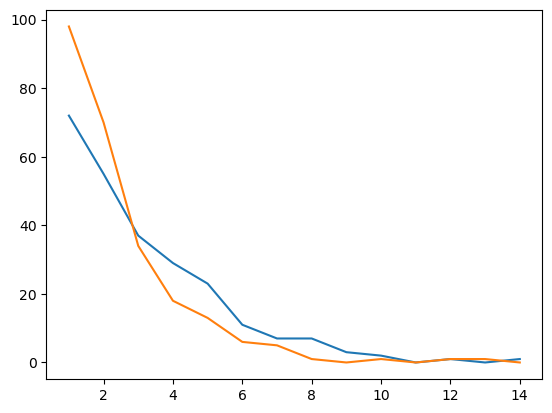

In [13]:
y0,x0 = np.histogram(tecrdb_dedup.loc[:,'nontrans_stderr'], range=(0,14), bins=14)
y1,x1 = np.histogram(tecrdb_dedup.loc[:,'stderr'], range=(0,14), bins=14)

plt.plot(x0[1:],y0)
plt.plot(x1[1:],y1)
plt.show()

In [14]:
formation_dg = pd.read_csv('./formation_dg_smiles.csv')
formation_dg_copy = formation_dg.loc[pd.notna(formation_dg.loc[:,'standard_dg_prime']),['name', 'Smiles', 'temperature', 'ionic_strength', 'p_h', 'p_mg', 'standard_dg_prime']].copy()
formation_dg_copy = formation_dg_copy.rename(columns={'name':'description', 'Smiles':'reaction', 'temperature':'T', 'ionic_strength':'I', 'p_h':'pH', 'p_mg':'pMg'})

In [15]:
formation_dg_dedup = pd.DataFrame(index=range(len(set(formation_dg_copy.reaction))), 
                            columns=['description', 'reaction', 'T', 'I', 'pH', 'pMg', 
                                     'standard_dg_prime', 'stderr', 'n', 'SEM'])
i = 0
formation_dg_copy.index = formation_dg_copy.reaction
for r in set(formation_dg_copy.index):
    reaction = formation_dg_copy.loc[[r],:]
    formation_dg_dedup.loc[i,'description'] = reaction.loc[:,'description'][0]
    formation_dg_dedup.loc[i,'reaction'] = r
    formation_dg_dedup.loc[i,'standard_dg_prime'] = reaction.loc[:,'standard_dg_prime'].mean()
    formation_dg_dedup.loc[i,'stderr'] = reaction.loc[:,'standard_dg_prime'].std(ddof=1)
    formation_dg_dedup.loc[i,'n'] = reaction.shape[0]
    formation_dg_dedup.loc[i,'SEM'] = reaction.loc[:,'standard_dg_prime'].sem(ddof=1)
    i += 1
formation_dg_dedup.loc[:,['T','I','pH','pMg']] = [default_T, default_I, default_pH, default_pMg]

In [16]:
TrainingData_df = pd.concat([formation_dg_dedup, tecrdb_dedup], axis=0)

TrainingData_df.to_csv('TrainingData.csv', index=False)